In [1]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code
# %run VIGOR_Functions
plt.style.use('./Figures/test.mplstyle')

## Define data path.
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/DATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1oxWJLF67TEifzQFgtUHIyhnEsS6AeQUW
    !unzip -qq /content/code/datacopy.zip
    root="/content/code/datacopy"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)


lickBug = []#'RatF01 RatF01_2021_07_21_16_21_18'
notfixed = ['RatM02 RatM02_2021_07_18_17_13_11', 'RatF00 RatF00_2021_08_19_13_14_34', 'RatF00 RatF00_2021_08_19_15_40_01', 'RatF01 RatF01_2021_07_21_16_21_18', 'RatF00 RatF00_2021_07_21_10_43_27', 'RatF00 RatF00_2021_07_21_15_19_33']
F00lostTRACKlick = ['RatF00 RatF00_2021_08_20_10_49_54', 'RatF00 RatF00_2021_08_20_15_40_51']
buggedRatSessions = ['RatF00 RatF00_2021_07_19_13_12_15']
boundariesBug = [["RatF00 RatF00_2021_07_19_15_25_33", [40, 20]], ["RatF01 RatF01_2021_07_19_11_09_43", [40,20]], ['RatM02 RatM02_2021_08_19_12_34_15', [35, 17]], ['RatM02 RatM02_2021_08_19_12_34_15', [35, 17]], ['RatM02 RatM02_2021_08_19_12_34_15', [35, 17]], ['RatF00 RatF00_2021_08_18_11_11_19', [75, 22]], ['RatF02 RatF02_2021_08_18_18_08_44', [75, 20]], ['RatF02 RatF02_2021_08_19_17_42_46', [40, 18]], ['RatF02 RatF02_2021_07_18_17_11_30', [75, 23]], ['RatF02 RatF02_2021_07_21_12_46_49', [43, 21]], ['RatF02 RatF02_2021_07_23_17_08_21', [75, 25]], ['RatF02 RatF02_2021_07_26_12_27_04', [40, 22]], ['RatF00 RatF00_2021_07_20_10_09_39', [100, 20]], ['RatF00 RatF00_2021_07_21_10_43_27', [40, 20]], ['RatF00 RatF00_2021_07_21_15_19_33', [40, 20]], ['RatF00 RatF00_2021_07_23_10_38_43', [75, 25]], ['RatF00 RatF00_2021_07_23_15_04_12', [75, 25]], ['RatF00 RatF00_2021_07_24_10_49_55', [100, 25]], ['RatF00 RatF00_2021_07_25_10_54_14', [75, 25]], ['RatF00 RatF00_2021_07_25_15_38_20', [75, 25]], ['RatF00 RatF00_2021_07_26_15_17_06', [45, 22]], ]
runstaysepbug = ['RatF00 RatF00_2021_07_18_10_36_33', 'RatM01 RatM01_2021_07_18_11_40_37', 'RatM01 RatM01_2021_07_18_16_12_12', 'RatM01 RatM01_2021_07_19_16_28_01', 'RatM00 RatM00_2021_08_19_15_40_49', 'RatF01 RatF01_2021_08_19_11_09_37', 'RatM02 RatM02_2021_07_21_12_48_07', 'RatM02 RatM02_2021_07_21_17_25_04', 'RatM02 RatM02_2021_07_25_17_37_53', 'RatM02 RatM02_2021_07_26_12_28_45', 'RatM02 RatM02_2021_07_26_17_21_19', 'RatM01 RatM01_2021_07_21_11_46_29', 'RatM01 RatM01_2021_07_26_11_26_38', 'RatM01 RatM01_2021_07_26_16_19_55', 'RatM00 RatM00_2021_07_21_10_45_30', 'RatM00 RatM00_2021_07_26_10_25_22', 'RatM00 RatM00_2021_07_26_15_18_23', 'RatF02 RatF02_2021_07_20_17_12_04', 'RatF00 RatF00_2021_07_20_10_09_39', 'RatF00 RatF00_2021_07_21_10_43_27', ] 

buggedSessions = lickBug, notfixed, F00lostTRACKlick, buggedRatSessions, boundariesBug, runstaysepbug


sessionLists = pickle.load(open("picklejar/sessionLists.p", "rb"))
trainDist, dist60, dist60bis, dist90, dist90bis, dist120, dist120bis, TMtrain, TMrev20, TMrev10, TMrev2, TM2, TM10, TM20 = sessionLists

Path to data is: /home/david/Desktop/DATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save


In [2]:
import glob, re, os
import VIGOR_utils as VIGutils

from scipy.ndimage import gaussian_filter as smooth
import itertools

In [11]:
PALETTE = {'RatF00': (0.55, 0.0, 0.0), 'RatF01': (0.8, 0.36, 0.36), 'RatF02': (1.0, 0.27, 0.0), 'RatF03': (.5, .5, .5),
            'RatM00': (0.0, 0.39, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2), 'RatM03': (.5, .5, .5)}

class ProcessData():
    def __init__(self, root, animal, sessionList, buggedSessions, redoMask=False):
        self.root = root
        self.animal = animal
        self.sessionList = sessionList
        self.lickBug, self.notfixed, self.F00lostTRACKlick, self.buggedRatSessions, self.boundariesBug, self.runstaysepbug = buggedSessions
        self.session = ''
        self.redoMask = redoMask
        # self.initializeVariables()

    def run(self):
        for self.session in self.sessionList:
            self.figPath = self.root+os.sep+self.animal+os.sep+"Experiments"+os.sep+self.session+os.sep+"Figures"+os.sep+"recapFIG%s.png" %self.session
            self.maskpicklePath = self.root+os.sep+self.animal+os.sep+"Experiments"+os.sep+self.session+os.sep+"Analysis"+os.sep+"mask.p"
            
            self.get_rat_colors()
            self.params = self.get_session_parameters()
            self.read_data_from_file()
            self.create_mask()
            self.extract_all_variables()
            self.save_variables()
            self.plot_recap_figure()

    def get_rat_colors(self):
        '''
        This function defines the color and the marker of the rat
        '''
        if fnmatch.fnmatch(self.animal, 'RatF*'):
            self.rat_markers = [PALETTE[self.animal], "$\u2640$"]
        elif fnmatch.fnmatch(self.animal, 'RatM*'):
            self.rat_markers = [PALETTE[self.animal], "$\u2642$"]
        elif fnmatch.fnmatch(self.animal, 'Rat00*'):
            self.rat_markers = [PALETTE[self.animal], "$\u2426$"]
        else:
            print("error, this is not a rat you got here")
        
    def get_session_parameters(self):
        '''
        This function reads the parameters of the session and returns a dictionary with the parameters
        Some parameters are computed from the raw data
        '''
        # compute the number of days since the last adlib
        lastDayadlib = str(datetime.datetime.strptime(str(VIGutils.read_params(root, self.animal, self.session, "lastDayadlib")), "%Y%m%d").date())
        stringmatch = re.search(r'\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}', self.session)
        experimentDay = str(datetime.datetime.strptime(stringmatch.group(), '%Y_%m_%d_%H_%M_%S'))
        daysSinceadlib = datetime.date(int(experimentDay[0:4]), int(experimentDay[5:7]), int(experimentDay[8:10])) - datetime.date(int(lastDayadlib[0:4]), int(lastDayadlib[5:7]), int(lastDayadlib[8:10]))

        # compute the real session duration      
        realEnd = VIGutils.read_params(root, self.animal, self.session, "ClockStop")
        if str(realEnd) != 'None':
            startExpe = datetime.time(int(experimentDay[11:13]), int(experimentDay[14:16]), int(experimentDay[17:19]))
            endExpe = datetime.time(hour=int(str(realEnd)[0:2]), minute=int(str(realEnd)[2:4]), second=int(str(realEnd)[4:6]))
            realSessionDuration = datetime.datetime.combine(datetime.date(1, 1, 1), endExpe) - datetime.datetime.combine(datetime.date(1, 1, 1), startExpe)
        else:
            realSessionDuration = None

        # get block parameter from file
        blocklist = []
        for blockN in range(1, 13):  # Max 12 blocks, coded in LabView...
            # add block if  block >0 seconds then get data from file.
            # Data from behav_params as follows: Block N°: // ON block Duration // OFF block duration // Repeat block // % reward ON // % reward OFF // Treadmill speed.
            if VIGutils.read_params(self.root, self.animal, self.session, "Block " + str(blockN), dataindex=-6, valueType=str) != 0:
                blocklist.append([VIGutils.read_params(self.root, self.animal, self.session, "Block " + str(blockN), dataindex=-6, valueType=str), 
                                    VIGutils.read_params(self.root, self.animal, self.session, "Block " + str(blockN), dataindex=-5, valueType=str),
                                    VIGutils.read_params(self.root, self.animal, self.session, "Block " + str(blockN), dataindex=-4, valueType=str), 
                                    VIGutils.read_params(self.root, self.animal, self.session, "Block " + str(blockN), dataindex=-3, valueType=str),
                                    VIGutils.read_params(self.root, self.animal, self.session, "Block " + str(blockN), dataindex=-2, valueType=str), 
                                    VIGutils.read_params(self.root, self.animal, self.session, "Block " + str(blockN), dataindex=-1, valueType=str), 
                                    blockN])
        # create an array [start_block, end_block] for each block using the values we have just read -> 1 block ON + 1 bloc OFF + etc.
        timecount, blockON_start, blockON_end, blockOFF_start, blockOFF_end = 0, 0, 0, 0, 0
        blocks = []  # blocks that we are going to use in the data processing. 1 block ON + 1 bloc OFF + etc.
        rewardP_ON = []  # probability of getting the reward in each ON phase
        rewardP_OFF = []  # same for OFF
        treadmillSpeed = []  # treadmill speed for each block (ON + OFF blocks not differenciated for now)
        rewardProbaBlock = []
        for block in blocklist:
            for repeat in range(0, block[2]):  # in essence blocks = [a, b], [b, c], [c, d], ...
                blockON_start = timecount
                timecount += block[0]
                blockON_end = timecount
                blockOFF_start = timecount
                timecount += block[1]
                blockOFF_end = timecount
                blocks.append([blockON_start, blockON_end])
                if blockOFF_start - blockOFF_end != 0:
                    blocks.append([blockOFF_start, blockOFF_end])
                rewardP_ON.append(block[3])
                rewardP_OFF.append(block[4])
                rewardProbaBlock.extend(block[3:5])
                treadmillSpeed.append(block[5])
                treadmillSpeed.append(block[5])

        session_params = {"sessionDuration": VIGutils.read_params(self.root, self.animal, self.session, "sessionDuration"),
                "acqPer": VIGutils.read_params(self.root, self.animal, self.session, "acqPer"),
                "waterLeft": round((VIGutils.read_params(self.root, self.animal, self.session, "waterLeft", valueType=float) - VIGutils.read_params(self.root, self.animal, self.session, "cupWeight", valueType=float))/10*1000, 2),
                "waterRight": round((VIGutils.read_params(self.root, self.animal, self.session, "waterRight", valueType=float) - VIGutils.read_params(self.root, self.animal, self.session, "cupWeight", valueType=float))/10*1000, 2),
                "treadmillDist": VIGutils.read_params(self.root, self.animal, self.session, "treadmillSize"),
                "weight": VIGutils.read_params(self.root, self.animal, self.session, "ratWeight"),
                "lastWeightadlib": VIGutils.read_params(self.root, self.animal, self.session, "ratWeightadlib"),
                "lastDayadlib": VIGutils.read_params(self.root, self.animal, self.session, "lastDayadlib"),
                "lickthresholdLeft": VIGutils.read_params(self.root, self.animal, self.session, "lickthresholdLeft"),  # added in Labview 2021/07/06. Now uses the custom lickthreshold for each side. Useful when lickdata baseline drifts and value is directly changed in LV. Only one session might be bugged, so this parameter is session specific. Before, the default value (300) was used and modified manually during the analysis.
                "lickthresholdRight": VIGutils.read_params(self.root, self.animal, self.session, "lickthresholdRight"),
                "brainstatus": VIGutils.read_params(self.root, self.animal, self.session, "brainstatus", valueType="other"),
                "boundaries": [],
                "daysSinceadLib": daysSinceadlib.days,
                "realSessionDuration": realSessionDuration,
                "blocks": blocks, 
                "rewardP_ON": rewardP_ON, 
                "rewardP_OFF": rewardP_OFF, 
                "treadmillSpeed": treadmillSpeed, 
                "rewardProbaBlock": rewardProbaBlock,
                }
                
        return session_params

    def read_data_from_file(self):
        # Read data from files
        file = self.root + os.sep + self.animal + os.sep + "Experiments" + os.sep + self.session + os.sep + self.session + ".position"
        extractTime      = VIGutils.read_csv_pandas(file, Col=[3])
        extractPositionX = VIGutils.read_csv_pandas(file, Col=[4])
        extractPositionY = VIGutils.read_csv_pandas(file, Col=[5])
        extractLickLeft  = VIGutils.read_csv_pandas(file, Col=[6])
        extractLickRight = VIGutils.read_csv_pandas(file, Col=[7])
        solenoid_ON_Left = VIGutils.read_csv_pandas(file, Col=[8])
        solenoid_ON_Right= VIGutils.read_csv_pandas(file, Col=[9])
        framebuffer      = VIGutils.read_csv_pandas(file, Col=[10])
        cameraEdit       = VIGutils.read_csv_pandas(file, Col=[11])

        # Cut leftover data at the end of the session (e.g. session is 1800s long, data goes up to 1820s because session has not been stopped properly/stopped manually, so we remove the extra 20s)
        rawTime          =      extractTime[extractTime <= self.params["sessionDuration"]]
        rawPositionX     = extractPositionX[extractTime <= self.params["sessionDuration"]]
        rawPositionY     = extractPositionY[extractTime <= self.params["sessionDuration"]]
        rawLickLeftX     =  extractLickLeft[extractTime <= self.params["sessionDuration"]]
        rawLickLeftY     =  extractLickLeft[extractTime <= self.params["sessionDuration"]]  # not needed, check
        rawLickRightX    = extractLickRight[extractTime <= self.params["sessionDuration"]]
        rawLickRightY    = extractLickRight[extractTime <= self.params["sessionDuration"]]  # not needed, check
        solenoid_ON_Left = solenoid_ON_Left[extractTime <= self.params["sessionDuration"]]
        solenoid_ON_Right=solenoid_ON_Right[extractTime <= self.params["sessionDuration"]]  # not needed, check
        cameraEdit       =       cameraEdit[extractTime <= self.params["sessionDuration"]]
        
        # convert data from px to cm
        rawPositionX, rawPositionY = VIGutils.datapx2cm(rawPositionX), VIGutils.datapx2cm(rawPositionY)
        rawSpeed = VIGutils.compute_speed(rawPositionX, rawTime)
        smoothMask = np.array([True])

        # usually rat is not found in the first few frames, so we replace Xposition by the first nonzero value
        # this is detected as a camera edit, so we fix that as well
        rawPositionX, cameraEdit = VIGutils.fix_start_session(rawPositionX, cameraEdit)
        rawPositionX = VIGutils.fixcamglitch(rawTime, rawPositionX, cameraEdit)


        # smoothing
        smoothPos, smoothSpeed = True, True
        sigmaPos, sigmaSpeed = 2, 2  # seems to work, less: not smoothed enough, more: too smoothed, not sure how to objectively compute an optimal value.
        if smoothPos == True:
            if smoothSpeed == True:
                rawPositionX = smooth(rawPositionX, sigmaPos)
                rawSpeed = smooth(VIGutils.compute_speed(rawPositionX, rawTime), sigmaSpeed)
            else:
                rawPositionX = smooth(rawPositionX, sigmaPos)

        ######################################################################################
        # LICKS AND WATER
        # Load lick data -- Licks == measure of conductance at the reward port. Conductance is ____ and when lick, increase of conductance so ___|_|___, we define it as a lick if it is above a threshold. But baseline value can randomly increase like this ___----, so baseline can be above threshold, so false detections. -> compute moving median to get the moving baseline (median, this way we eliminate the peaks in the calculation of the baseline) and then compare with threshold. __|_|__---|---|----
        window = 200
        if self.params["lickthresholdLeft"] == None:
            self.params["lickthresholdLeft"] = 300
        if self.params["lickthresholdRight"] == None:
            self.params["lickthresholdRight"] = 300
        rawLickLeftX = [k if i-j >= self.params["lickthresholdLeft"] else 0 for i, j, k in zip(rawLickLeftX, VIGutils.movinmedian(rawLickLeftX, window), rawPositionX)]
        rawLickRightX = [k if i-j >= self.params["lickthresholdRight"] else 0 for i, j, k in zip(rawLickRightX, VIGutils.movinmedian(rawLickRightX, window), rawPositionX)]

        # Specify if a session has lick data problems, so we don't discard the whole session (keep the run behavior, remove lick data)
        if all(v == 0 for v in rawLickLeftX):
            self.params["hasLick"] = False
        elif all(v == 0 for v in rawLickRightX):
            self.params["hasLick"] = False
        elif self.animal + " " + self.session in lickBug:
            self.params["hasLick"] = False
        else:
            self.params["hasLick"] = True

        # Water data. Drop size and volume rewarded. Compute drop size for each reward port. Determine if drops are equal, or which one is bigger. Assign properties (e.g. line width for plots) accordingly.
        limitWater_diff = 5
        watL = round(self.params["waterLeft"], 1)  # print(round(self.params["waterLeft"], 1), "µL/drop")
        watR = round(self.params["waterRight"], 1)  # print(round(self.params["waterRight"], 1), "µL/drop")
        if watL-(watL*limitWater_diff/100) <= watR <= watL+(watL*limitWater_diff/100):
            water = ["Same Reward Size", "Same Reward Size", 2, 2]  # print(session, "::", watL, watR, "     same L-R") #print(watL-(watL*limitWater_diff/100)) #print(watL+(watL*limitWater_diff/100))
        elif watL < watR:
            water = ["Small Reward", "Big Reward", 1, 5]  # print(session, "::", watL, watR, "     bigR")
        elif watL > watR:
            water = ["Big Reward", "Small Reward", 5, 1]  # print(session, "::", watL, watR, "     bigL")
        else:
            water = ["r", "r", 1, 1]

        border = 5  # define arbitrary border
        leftBoundaryPeak, rightBoundaryPeak, kde = VIGutils.extract_boundaries(rawPositionX, self.params['treadmillDist'], height=0.001)

        self.params["boundaries"] = [rightBoundaryPeak - border, leftBoundaryPeak + border]
        self.rawPositionX, self.rawPositionY, self.rawSpeed, self.rawTime = rawPositionX, rawPositionY, rawSpeed, rawTime
        self.rawLickLeftX, self.rawLickRightX = rawLickLeftX, rawLickRightX
        self.solenoid_ON_Left, self.solenoid_ON_Right = solenoid_ON_Left, solenoid_ON_Right

    def create_mask(self):
        if os.path.exists(self.maskpicklePath) and (not self.redoMask):
            self.binMask = VIGutils.get_from_pickle(self.root, self.animal, self.session, name="mask.p")
        else:
            if self.animal + " " + self.session in runstaysepbug:
                septhreshold = 0.0004   # threshold 0.0004 seems to work ok for all TM distances. lower the thresh the bigger the wait blob zone taken, which caused problems in 60cm configuration.
            else:
                septhreshold = 0.0002
            rawMask = VIGutils.filterspeed(self.rawPositionX, self.rawSpeed, septhreshold, self.params["treadmillDist"])
            self.smoothMask = VIGutils.removeSplits_Mask(rawMask, self.rawPositionX, self.params["treadmillDist"])
            self.binMask = VIGutils.fixSplittedRunsMask(VIGutils.bin_session(self.smoothMask, self.rawTime, self.params["blocks"]), self.params["blocks"])
        
        self.smoothMask = VIGutils.stitch([self.binMask])[0]
        running_Xs = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(self.rawPositionX, self.smoothMask)]]
        idle_Xs    = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(self.rawPositionX, self.smoothMask)]]
        speed_while_running  = [val[0] if val[1] == True else None for val in [[i, j] for i, j in zip(self.rawSpeed, self.smoothMask)]]
        speed_while_waiting   = [val[0] if val[1] == False else None for val in [[i, j] for i, j in zip(self.rawSpeed, self.smoothMask)]]
        self.binSpeed = VIGutils.reCutBins(self.rawSpeed, self.binMask)
        self.binTime = VIGutils.reCutBins(self.rawTime, self.binMask)
        self.binPositionX = VIGutils.reCutBins(self.rawPositionX, self.binMask)
        self.binPositionY = VIGutils.reCutBins(self.rawPositionY, self.binMask)
        self.binLickLeftX = VIGutils.reCutBins(self.rawLickLeftX, self.binMask)
        self.binLickRightX = VIGutils.reCutBins(self.rawLickRightX, self.binMask)
        self.binSolenoid_ON_Left = VIGutils.reCutBins(self.solenoid_ON_Left, self.binMask)
        self.binSolenoid_ON_Right = VIGutils.reCutBins(self.solenoid_ON_Right, self.binMask)

    def extract_all_variables(self):
        # Extract all variables.
        (speedRunToRightBin, speedRunToLeftBin, XtrackRunToRightBin, XtrackRunToLeftBin, 
            timeRunToRightBin, timeRunToLeftBin, timeStayInRightBin, timeStayInLeftBin, 
            XtrackStayInRightBin, XtrackStayInLeftBin, TtrackStayInRightBin, TtrackStayInLeftBin, 
            instantSpeedRightBin, instantSpeedLeftBin, maxSpeedRightBin, maxSpeedLeftBin, 
            whenmaxSpeedRightBin, whenmaxSpeedLeftBin, wheremaxSpeedRightBin, wheremaxSpeedLeftBin, 
            lick_arrivalRightBin, lick_drinkingRightBin, lick_waitRightBin, 
            lick_arrivalLeftBin, lick_drinkingLeftBin, lick_waitLeftBin, 
            rewardedRightBin, rewardedLeftBin) = VIGutils.extract_runSpeedBin(self.binPositionX, self.binSpeed, self.binTime, 
                                            self.binLickRightX, self.binLickLeftX, self.binSolenoid_ON_Right, self.binSolenoid_ON_Left, 
                                            self.binMask, self.params['blocks'], self.params["boundaries"],  
                                            self.params["treadmillSpeed"], self.params['rewardProbaBlock'])
        
        (speedRunToRight,    speedRunToLeft,    XtrackRunToRight,    XtrackRunToLeft,    
            timeRunToRight,    timeRunToLeft,    timeStayInRight,    timeStayInLeft,    
            XtrackStayInRight,    XtrackStayInLeft,    TtrackStayInRight,    TtrackStayInLeft,    
            instantSpeedRight,    instantSpeedLeft,    maxSpeedRight,    maxSpeedLeft,    
            whenmaxSpeedRight,    whenmaxSpeedLeft,    wheremaxSpeedRight,    wheremaxSpeedLeft,    
            lick_arrivalRight,    lick_drinkingRight,    lick_waitRight,    lick_arrivalLeft,    
            lick_drinkingLeft,    lick_waitLeft, rewardedRight, rewardedLeft) = VIGutils.stitch(
                [speedRunToRightBin, speedRunToLeftBin, XtrackRunToRightBin, XtrackRunToLeftBin, 
                timeRunToRightBin, timeRunToLeftBin, timeStayInRightBin, timeStayInLeftBin, 
                XtrackStayInRightBin, XtrackStayInLeftBin, TtrackStayInRightBin, TtrackStayInLeftBin, 
                instantSpeedRightBin, instantSpeedLeftBin, maxSpeedRightBin, maxSpeedLeftBin, 
                whenmaxSpeedRightBin, whenmaxSpeedLeftBin, wheremaxSpeedRightBin, wheremaxSpeedLeftBin, 
                lick_arrivalRightBin, lick_drinkingRightBin, lick_waitRightBin, lick_arrivalLeftBin, 
                lick_drinkingLeftBin, lick_waitLeftBin, rewardedRightBin, rewardedLeftBin])
        
        nb_runs_to_rightBin, nb_runs_to_leftBin, nb_runsBin = {}, {}, {}
        for i in range(0, len(self.params['blocks'])):
            nb_runs_to_rightBin[i] = len(speedRunToRightBin[i])
            nb_runs_to_leftBin[i] = len(speedRunToLeftBin[i])
            nb_runsBin[i] = len(speedRunToRightBin[i]) + len(speedRunToLeftBin[i])
            total_trials = nb_runsBin[i]

        nb_rewardBlockLeft, nb_rewardBlockRight, nbWaterLeft, nbWaterRight = {}, {}, 0, 0
        for i in range(0, len(self.params['blocks'])):
            nb_rewardBlockLeft[i] = sum([1 if t[0] <= self.params['rewardProbaBlock'][i] else 0 for t in VIGutils.split_a_list_at_zeros(self.binSolenoid_ON_Left[i])])  # split a list because in data file we have %open written along valve opening time duration (same value multiple time), so we only take the first one, verify >threshold, ...
            nb_rewardBlockRight[i] = sum([1 if t[0] <= self.params['rewardProbaBlock'][i] else 0 for t in VIGutils.split_a_list_at_zeros(self.binSolenoid_ON_Right[i])])  # print(i+1, nb_rewardBlockLeft[animal, session][i], nb_rewardBlockRight[animal, session][i])
        nbWaterLeft = sum(nb_rewardBlockLeft.values())
        nbWaterRight = sum(nb_rewardBlockRight.values())
        totalWater = round((nbWaterLeft * self.params["waterLeft"] + nbWaterRight * self.params["waterRight"])/1000, 2), 'mL'  # totalWater = nbWaterLeft[animal, session] * params[animal, session]["waterLeft"], "+", nbWaterRight[animal, session] * params[animal, session]["waterRight"]

        # compute total X distance moved during the session for each rat. maybe compute XY.
        totalDistance = sum(abs(np.diff(self.rawPositionX)))/100

        # sequences
        changes = np.argwhere(np.diff(self.smoothMask)).squeeze()
        full = []
        full.append(self.smoothMask[:changes[0]+1])
        for i in range(0, len(changes)-1):
            full.append(self.smoothMask[changes[i]+1:changes[i+1]+1])
        full.append(self.smoothMask[changes[-1]+1:])
        fulltime = VIGutils.recut(self.rawTime, full)
        openings = VIGutils.recut(self.solenoid_ON_Left + self.solenoid_ON_Right, full)
        positions = VIGutils.recut(self.rawPositionX, full)
        sequence = {}
        for item, (j, t, o, p) in enumerate(zip(full, fulltime, openings, positions)):
            proba = VIGutils.split_a_list_at_zeros(o)[0][0] if np.any(VIGutils.split_a_list_at_zeros(o)) else 100
            #     #action start time        #run or stay       #get reward (1) or not (0)                                                        #action duration       #dist/time=avg speed if run 
            sequence[item] = t[0], "run" if j[0] == True else "stay", 1 if proba < self.params['rewardProbaBlock'][VIGutils.get_block(t[0])] else 0, t[-1] - t[0], (p[-1] - p[0])/(t[-1] - t[0]) if j[0] == True else "wait"

    def save_variables(self):
        pass

    def plot_recap_figure(self):
        fig = plt.figure(constrained_layout=False, figsize=(32, 42))
        fig.suptitle(self.session, y=0.9, fontsize=24)
        gs = fig.add_gridspec(75, 75)
        ax00 = fig.add_subplot(gs[0:7, 0:4])
        ax00 = plot_peak(rawPositionX, animal, session, leftBoundaryPeak, rightBoundaryPeak, kde, [0.05, 0, 0], [0, 120, 0],  marker=[""], xyLabels=["Position (cm)", "%"])
        ax01 = fig.add_subplot(gs[0:7, 5:75])
        ax01 = plot_BASEtrajectoryV2(animal, session, rawTime, running_Xs, idle_Xs, rawLickLeftX, rawLickRightX, params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes=[0, params[animal, session]['sessionDuration'], 50, 90, 0, 22, 10],  xyLabels=["Time (min)", " ", "Position (cm)", "", "", "", 14, 12], title=[session, "", " ", "", 16], linewidth=[1.5])
        plt.plot([0, params[animal, session]['sessionDuration']], [params[animal, session]["boundaries"][0], params[animal, session]["boundaries"][0]], ":", color='k', alpha=0.5)
        plt.plot([0, params[animal, session]['sessionDuration']], [params[animal, session]["boundaries"][1], params[animal, session]["boundaries"][1]], ":", color='k', alpha=0.5)

        gs00 = gs[8:13, 0:75].subgridspec(2, 75)
        ax11 = fig.add_subplot(gs00[0, 5:75])
        ax12 = fig.add_subplot(gs00[1, 0:75])
        ax11.plot(rawTime, speed_while_running, color='dodgerblue')
        ax11.plot(rawTime, speed_while_waiting, color='orange')
        ax11.set_xlabel('time (s)')
        ax11.set_ylabel('speed (cm/s)')
        ax11.set_xlim(0, 3600)
        ax11.set_ylim(-200, 200)
        ax11.spines['top'].set_color("none")
        ax11.spines['right'].set_color("none")
        ax11.spines['left'].set_color("none")
        ax11.spines['bottom'].set_color("none")
        ax12.scatter(rawPositionX, speed_while_running, color='dodgerblue', s=0.5)
        ax12.scatter(rawPositionX, speed_while_waiting, color='orange', s=0.5)
        ax12.set_xlabel('position (cm)')
        ax12.set_ylabel('speed (cm/s)')
        ax12.set_xlim(0, 130)
        ax12.set_ylim(-150, 150)
        ax12.spines['top'].set_color("none")
        ax12.spines['right'].set_color("none")
        ax12.spines['left'].set_color("none")
        ax12.spines['bottom'].set_color("none")
        yline = [0, 120]
        xline = [0, 0]
        ax12.plot(yline, xline, ":", color='k')

        ax20 = fig.add_subplot(gs[17:22, 0:10])
        ax20 = plot_tracks(animal, session, XtrackRunToRight, timeRunToRight, params[animal, session]["boundaries"], xylim=[-0.1, 2, 0, 120], color=['paleturquoise', 'tomato'],  xyLabels=["Time (s)", "X Position (cm)", 14], title=["Tracking run to Right",  16], linewidth=[1.5])
        ax21 = fig.add_subplot(gs[17:22, 15:25])
        ax21 = plot_tracks(animal, session, XtrackRunToLeft, timeRunToLeft, params[animal, session]["boundaries"], xylim=[-0.1, 2, 0, 120], color=['darkcyan', 'darkred'], xyLabels=["Time (s)", "", 14], title=["Tracking run to Left", 16], linewidth=[1.5])
        ax20 = fig.add_subplot(gs[17:22, 30:40])
        ax20 = cumul_plot(speedRunToRight, speedRunToLeft, barplotaxes=[0, 120, 0, 1], maxminstepbin=[0, 120, 1], scatterplotaxes=[0, 0, 0, 0], color=['paleturquoise', 'darkcyan', 'tomato', 'darkred'], xyLabels=["Speed cm/s", "Cumulative Frequency Run Speed", 14, 12], title=["Cumulative Plot Good Run Speed", 16], linewidth=[1.5], legend=["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax21 = fig.add_subplot(gs[17:22, 45:55])
        ax21 = distribution_plot(speedRunToRight, speedRunToLeft, barplotaxes=[0, 0, 0, 0], maxminstepbin=[0, 120, 1], scatterplotaxes=[0.5, 2.5, 0, 120], color=['paleturquoise', 'darkcyan', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Run Speed", 16], linewidth=[1.5], legend=["To Right: Good Runs ", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])

        gs23 = gs[15:22, 60:75].subgridspec(5, 2)
        ax231 = fig.add_subplot(gs23[0:2, 0:2])
        if len(framebuffer[animal, session]) != 0:
            ax231.set_title("NbBug/TotFrames: %s/%s = %.2f" % (sum(np.diff(framebuffer[animal, session])-1), len(framebuffer[animal, session]), sum(np.diff(framebuffer[animal, session])-1)/len(framebuffer[animal, session])), fontsize=16)
        ax231.scatter(list(range(1, len(framebuffer[animal, session]))), [x-1 for x in np.diff(framebuffer[animal, session])], s=5)
        ax231.set_xlabel("frame index")
        ax231.set_ylabel("dFrame -1 (0 is ok)")
        ax232 = fig.add_subplot(gs23[3:5, 0:2])
        ax232.set_title(params[animal, session]["realSessionDuration"], fontsize=16)
        ax232.plot(np.diff(rawTime[animal, session]), label="data")
        ax232.plot(movinavg(np.diff(rawTime[animal, session]), 100), label="moving average")
        ax232.set_xlim(0, len(np.diff(rawTime[animal, session])))
        ax232.set_ylim(0, 0.1)
        ax232.set_xlabel("frame index")
        ax232.set_ylabel("time per frame (s)")

        ax30 = fig.add_subplot(gs[25:30, 0:10])
        ax30 = cumul_plot(maxSpeedRight, maxSpeedLeft, barplotaxes=[0, 200, 0, 1], maxminstepbin=[0, 200, 1], scatterplotaxes=[0.5, 2.5, 0, 100], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed cm/s", "Cumulative Frequency MAX Run Speed", 14, 12], title=["Cumulative Plot MAX Run Speed", 16], linewidth=[1.5], legend=["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax31 = fig.add_subplot(gs[25:30, 15:25])
        ax31 = distribution_plot(maxSpeedRight, maxSpeedLeft, barplotaxes=[0, 100, 0, 1], maxminstepbin=[0, 100, 1], scatterplotaxes=[0.5, 2.5, 0, 200], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of MAX Run Speed", 16], linewidth=[1.5], legend=["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
        ax32 = fig.add_subplot(gs[25:30, 30:40])
        ax32 = plot_speed(animal, session, instantSpeedRight, timeRunToRight, [0, 0], xylim=[-0.1, 4, 0, 200], xyLabels=["Time (s)", "X Speed (cm/s)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth=[1.5])
        ax33 = fig.add_subplot(gs[25:30, 45:55])
        ax33 = plot_speed(animal, session, instantSpeedLeft, timeRunToLeft, [0, 0], xylim=[-0.1, 4, 0, 200], xyLabels=["Time (s)", "", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth=[1.5])
        ax34 = fig.add_subplot(gs[25:30, 60:70])
        ax34 = plot_speed(animal, session, instantSpeedRight[animal, session] + instantSpeedLeft, timeRunToRight[animal, session] + timeRunToLeft, [0, 0], xylim=[-0.1, 4, 0, 200], xyLabels=["Time (s)", "", 14], title=["Speed" + "\n" + " To left and to right", 12], linewidth=[0.5])

        ax40 = fig.add_subplot(gs[35:40, 0:8])
        ax40 = cumul_plot(maxSpeedRight, maxSpeedLeft, barplotaxes=[0, 250, 0, 1], maxminstepbin=[0, 250, 1], scatterplotaxes=[0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed cm/s", "Cumulative Frequency MAX Run Speed", 14, 12], title=["CumulPlt MAXrunSpeed <TreadmillCorrected>", 16], linewidth=[1.5], legend=["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax41 = fig.add_subplot(gs[35:40, 12:23])
        ax41 = distribution_plot(maxSpeedRight, maxSpeedLeft, barplotaxes=[0, 0, 0, 0], maxminstepbin=[0, 0, 0], scatterplotaxes=[0.5, 2.5, 0, 250], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distr. of MAXrunSpeed <TreadmillCorrected>", 16], linewidth=[1.5], legend=["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
        ax42 = fig.add_subplot(gs[35:40, 26:34])  # where maxspeed
        ax42 = cumul_plot(wheremaxSpeedRight, wheremaxSpeedLeft, barplotaxes=[0, 120, 0, 1], maxminstepbin=[0, 120, 1], scatterplotaxes=[0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Position maxSpeed reached (cm)", "Cumulative Frequency MAX runSpeed Position", 14, 12], title=["CumulPlt MAXrunSpeed \nPosition from start of run", 16], linewidth=[1.5], legend=["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax43 = fig.add_subplot(gs[35:40, 38:49])
        ax43 = distribution_plot(wheremaxSpeedRight, wheremaxSpeedLeft, barplotaxes=[0, 0, 0, 0], maxminstepbin=[0, 0, 0], scatterplotaxes=[0.5, 2.5, 0, 120], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["X Position (cm)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distr. MAXrunSpeed \nPosition from start of run", 16], linewidth=[1.5], legend=["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
        ax44 = fig.add_subplot(gs[35:40, 52:60])  # when maxspeed
        ax44 = cumul_plot(whenmaxSpeedRight, whenmaxSpeedLeft, barplotaxes=[0, 2.5, 0, 1], maxminstepbin=[0, 2.5, 0.04], scatterplotaxes=[0, 0, 0, 0], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Time MAX runSpeed reached (s)", "Cumulative Frequency", 14, 12], title=["CumulPlt Time of \nMAXrunSpeed from start of run", 16], linewidth=[1.5], legend=["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax45 = fig.add_subplot(gs[35:40, 64:75])
        ax45 = distribution_plot(whenmaxSpeedRight, whenmaxSpeedLeft, barplotaxes=[0, 0, 0, 0], maxminstepbin=[0, 0, 0], scatterplotaxes=[0.5, 2.5, 0, 2.5], color=['lightgreen', 'darkgreen', 'tomato', 'darkred'], xyLabels=["Time MAX runSpeed reached (s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distr. Time of MAXrunSpeed \nfrom start of run", 16], linewidth=[1.5], legend=["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])

        ax50 = fig.add_subplot(gs[45:50, 0:10])
        ax50 = plot_tracks(animal, session, XtrackStayInRight, TtrackStayInRight, params[animal, session]["boundaries"], xylim=[-1, 10, params[animal, session]['treadmillDist']-40, params[animal, session]['treadmillDist']], color=['moccasin', 'tomato'], xyLabels=["Time (s)", "X Position (cm)", 14, 12], title=["Tracking in Right", 16], linewidth=[1.5])
        ax51 = fig.add_subplot(gs[45:50, 15:25])
        ax51 = plot_tracks(animal, session, XtrackStayInLeft, TtrackStayInLeft, params[animal, session]["boundaries"], xylim=[-1, 10, 0, 40], color=['darkorange', 'darkred'], xyLabels=["Time (s)", "", 14, 12], title=["Tracking in Left", 16], linewidth=[1.5])
        ax52 = fig.add_subplot(gs[45:50, 30:40])
        ax52 = cumul_plot(timeStayInRight, timeStayInLeft, barplotaxes=[0, 15, 0, 1], maxminstepbin=[0, 15, 0.1], scatterplotaxes=[0, 0, 0, 0], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time in zone (s)", "Cumulative Frequency Time In Zone", 14, 12], title=["Cumulative Plot Good Time In Zone", 16], linewidth=[1.5], legend=["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax53 = fig.add_subplot(gs[45:50, 45:60])
        ax53 = distribution_plot(timeStayInRight, timeStayInLeft, barplotaxes=[0, 0, 0, 0], maxminstepbin=[0, 30, 1], scatterplotaxes=[0.5, 2.5, 0, 30], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time in zone (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Time In Zone", 16], linewidth=[1.5], legend=["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])

        ax60 = fig.add_subplot(gs[55:60, 0:8])
        ax60 = cumul_plot(lick_arrivalRight, lick_arrivalLeft, barplotaxes=[0, 2, 0, 1], maxminstepbin=[0, 2, 0.1], scatterplotaxes=[0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Cumulative Frequency", 14, 12], title=["Cumulative Plot preDrink Time", 16], linewidth=[1.5], legend=["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax61 = fig.add_subplot(gs[55:60, 12:23])
        ax61 = distribution_plot(lick_arrivalRight, lick_arrivalLeft, barplotaxes=[0, 100, 0, 1], maxminstepbin=[0, 100, 1], scatterplotaxes=[0.5, 2.5, 0, 2], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution preDrink Time", 16], linewidth=[1.5], legend=["In Right", "In Left", " ", " "])
        ax62 = fig.add_subplot(gs[55:60, 26:34])
        ax62 = cumul_plot(lick_drinkingRight, lick_drinkingLeft, barplotaxes=[0, 4, 0, 1], maxminstepbin=[0, 4, 0.1], scatterplotaxes=[0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Cumulative Frequency", 14, 12], title=["Cumulative Plot Drink Time", 16], linewidth=[1.5], legend=["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax63 = fig.add_subplot(gs[55:60, 38:49])
        ax63 = distribution_plot(lick_drinkingRight, lick_drinkingLeft, barplotaxes=[0, 100, 0, 1], maxminstepbin=[0, 100, 1], scatterplotaxes=[0.5, 2.5, 0, 4], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of Drink Time", 16], linewidth=[1.5], legend=["In Right", "In Left", " ", " "])
        ax64 = fig.add_subplot(gs[55:60, 52:60])
        ax64 = cumul_plot(lick_waitRight, lick_waitLeft, barplotaxes=[0, 10, 0, 1], maxminstepbin=[0, 10, 0.1], scatterplotaxes=[0.5, 2.5, 0, 100], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Cumulative Frequency", 14, 12], title=["Cumulative Plot postDrink Time", 16], linewidth=[1.5], legend=["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
        ax65 = fig.add_subplot(gs[55:60, 64:75])
        ax65 = distribution_plot(lick_waitRight, lick_waitLeft, barplotaxes=[0, 100, 0, 1], maxminstepbin=[0, 100, 1], scatterplotaxes=[0.5, 2.5, 0, 10], color=['moccasin', 'darkorange', 'tomato', 'darkred'], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of postDrink Time", 16], linewidth=[1.5], legend=["In Right", "In Left", " ", " "])

        if len(params[animal, session]['blocks']) > 1:
            stat = "Med. "
            ax70 = fig.add_subplot(gs[63:70, 0:9])
            ax70 = plot_figBin([nb_runsBin[animal, session][i]/(int((blocks[i][1]-blocks[i][0])/60)) for i in range(0, len(blocks))], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes=[0, params[animal, session]['sessionDuration']/60, 0, 25], color=['k'], xyLabels=["Time (min)", "\u0023 runs / min", 14, 12], title=["", 16], linewidth=[1.5], stat=stat)
            ax72 = fig.add_subplot(gs[63:70, 20:29])
            ax72 = plot_figBin([speedRunToLeftBin[animal, session][i] + speedRunToRightBin[animal, session][i] for i in range(0, len(blocks))], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes=[0, params[animal, session]['sessionDuration']/60, 0, 100], color=['dodgerblue'], xyLabels=["Time (min)", "Avg. run speed (cm/s)", 14, 12], title=["", 16], linewidth=[1.5], scatter=True, stat=stat)
            ax74 = fig.add_subplot(gs[63:70, 40:49])
            ax74 = plot_figBin([maxSpeedRightBin[animal, session][i] + maxSpeedLeftBin[animal, session][i] for i in range(0, len(blocks))], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes=[0, params[animal, session]['sessionDuration']/60, 0, 150], color=['red'], xyLabels=["Time (min)", "Average max speed (cm/s)", 14, 12], title=["", 16], linewidth=[1.5], scatter=True, stat=stat)
            ax76 = fig.add_subplot(gs[63:70, 60:69])
            ax76 = plot_figBin([timeStayInLeftBin[animal, session][i] + timeStayInRightBin[animal, session][i] for i in range(0, len(blocks))], params[animal, session]['rewardProbaBlock'], params[animal, session]['blocks'], barplotaxes=[0, params[animal, session]['sessionDuration']/60, 0, 25], color=['orange'], xyLabels=["Time (min)", "Avg. time in sides (s)", 14, 12], title=["", 16], linewidth=[1.5], scatter=True, stat=stat)

            ax71 = fig.add_subplot(gs[63:70, 10:15])
            ax71 = plot_figBinMean(ax71, [i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_OFF"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock']))], [i/(int((params[animal, session]['blocks'][block][1]-params[animal, session]['blocks'][block][0])/60)) for block, i in enumerate(poolByReward([nb_runsBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock']))], color=['k'], ylim=(0, 25))
            ax73 = fig.add_subplot(gs[63:70, 30:35])
            ax73 = plot_figBinMean(ax73, [np.mean(i) for i in poolByReward([speedRunToRightBin, speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], [np.mean(i) for i in poolByReward([speedRunToRightBin, speedRunToLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], color=['dodgerblue'], ylim=(0, 100))
            ax75 = fig.add_subplot(gs[63:70, 50:55])
            ax75 = plot_figBinMean(ax75, [np.mean(i) for i in poolByReward([maxSpeedRightBin, maxSpeedLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], [np.mean(i) for i in poolByReward([maxSpeedRightBin, maxSpeedLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], color=['red'], ylim=(0, 150))
            ax77 = fig.add_subplot(gs[63:70, 70:75])
            ax77 = plot_figBinMean(ax77, [np.mean(i) for i in poolByReward([timeStayInRightBin, timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_OFF"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], [np.mean(i) for i in poolByReward([timeStayInRightBin, timeStayInLeftBin[animal, session]], params[animal, session]["rewardP_ON"][0], params[animal, session]['blocks'], params[animal, session]['rewardProbaBlock'])], color=['orange'], ylim=(0, 25))

        # %config InlineBackend.print_figure_kwargs = {'bbox_inches':None} #use % in notebook
        ax80 = fig.add_subplot(gs[73:74, 0:60])
        ax80.spines['top'].set_color("none")
        ax80.spines['right'].set_color("none")
        ax80.spines['left'].set_color("none")
        ax80.spines['bottom'].set_color("none")
        ax80.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax80.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        text = ("sessionDuration: {0} | acqPer: {1} | waterLeft: {2} | waterRight: {3} | treadmillDist: {4} | weight: {5} | lastWeightadlib: {6} | lastDayadlib: {7} | lickthresholdLeft: {8} | lickthresholdRight: {9} | realEnd: {10} | boundaries: {11} | daysSinceadLib: {12} \n realSessionDuration: {13} | blocks: {14} | \n rewardP_ON: {15} | rewardP_OFF: {16} | treadmillSpeed: {17} | rewardProbaBlock: {18} | hasLick: {19}").format(params[animal, session]['sessionDuration'], params[animal, session]['acqPer'], params[animal, session]['waterLeft'], params[animal, session]['waterRight'], params[animal, session]['treadmillDist'], params[animal, session]['weight'], params[animal, session]['lastWeightadlib'], params[animal, session]['lastDayadlib'], params[animal, session]['lickthresholdLeft'], params[animal, session]['lickthresholdRight'], params[animal, session]['realEnd'], params[animal, session]['boundaries'], params[animal, session]['daysSinceadLib'], params[animal, session]['realSessionDuration'], params[animal, session]['blocks'], params[animal, session]['rewardP_ON'], params[animal, session]['rewardP_OFF'], params[animal, session]['treadmillSpeed'], params[animal, session]['rewardProbaBlock'], params[animal, session]['hasLick'])
        ax80 = plt.text(0 ,0, str(text), wrap=True)
# speed_while_running, speed_while_waiting

NameError: name 'plot_peak' is not defined

<Figure size 432x288 with 0 Axes>

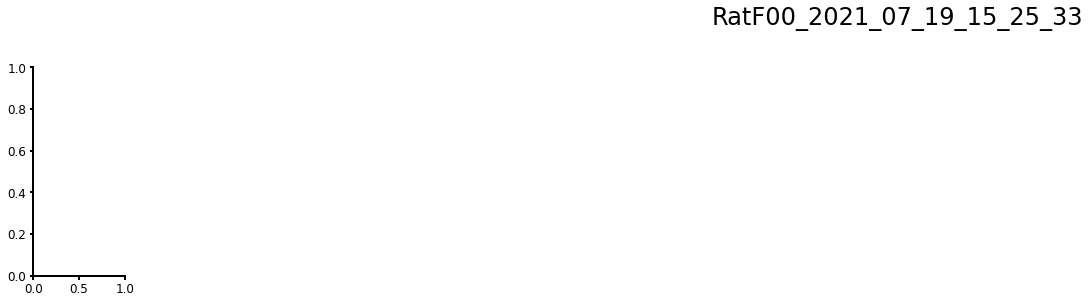

In [12]:
import glob, re, os
import VIGOR_utils as VIGutils
import VIGOR_plotting as VIGplot

from scipy.ndimage import gaussian_filter as smooth
import itertools

# %run VIGOR_utils
%run VIGOR_plotting
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]
animal = animalList[0]
sessionList = dist60[2:4]
sessionList = ['RatF00_2021_07_19_15_25_33']

p = ProcessData(root, animal, sessionList, buggedSessions, redoMask=False)
p.run()
p.params['boundaries']